# exp023
co-visitation-matrix検討

In [1]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from dotenv import load_dotenv
load_dotenv
sys.path.append(os.getenv('UTILS_PATH'))
from tqdm import tqdm
import multiprocessing
import inspect

import pandas as pd
import numpy as np
import itertools
import cudf
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import line_notify
import my_logger
from noglobal import noglobal

# 設定

In [2]:
@dataclass
class Cfg:
    loglevel = "INFO"
    exp_name = "exp023_0"
    seed = 42
    k = 20
    type2id = {"clicks":0, "carts":1, "orders":2}
    id2type = {0:"clicks", 1:"carts", 2:"orders"}
    train_weeks = ["week3"]
    valid_week = "week4"
    valid_session_n = 1_000_000
    input_dir = os.getenv('INPUT_DIR')
    output_dir = os.getenv('OUTPUT_DIR')
    prep_dir = os.getenv("PREP_DIR")

cfg = Cfg()
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)
random.seed(cfg.seed)

logger = my_logger.init_logger(cfg.exp_name)

In [3]:
@noglobal(excepts=["cfg", "logger"])
def evaluate(clicks_labels, carts_labels, orders_labels, 
             clicks_preds, carts_preds, orders_preds, k=20):

    num_clicks = 0
    num_carts = 0
    num_orders = 0
    hit_clicks = 0
    hit_carts = 0
    hit_orders = 0

    for i in range(len(clicks_labels)):
        clicks_label = clicks_labels[i]
        carts_label = carts_labels[i]
        orders_label = orders_labels[i]
        clicks_pred = clicks_preds[i]
        carts_pred = carts_preds[i]
        orders_pred = orders_preds[i]

        if type(clicks_pred) == list:
            clicks_pred = clicks_pred[:k]
        else:
            clicks_pred = []
        if type(carts_pred) == list:
            carts_pred = carts_pred[:k]
        else:
            carts_pred = []    
        if type(orders_pred) == list:
            orders_pred = orders_pred[:k]
        else:
            orders_pred = []

        if not np.isnan(clicks_label):
            num_clicks += 1
            hit_clicks += int(clicks_label in clicks_pred)

        if type(carts_label) == list:
            num_carts += min(len(carts_label), k)
            hit_carts += len(set(carts_pred) & set(carts_label))
            
        if type(orders_label) == list:
            num_orders += min(len(orders_label), k)
            hit_orders += len(set(orders_pred) & set(orders_label))


    recall_clicks = hit_clicks / num_clicks
    recall_carts = hit_carts / num_carts
    recall_orders = hit_orders / num_orders
    w_recall_clicks = recall_clicks * 0.10
    w_recall_carts = recall_carts * 0.30
    w_recall_orders = recall_orders * 0.6
    score = w_recall_clicks + w_recall_carts + w_recall_orders

    results = {}
    results["num_clicks"] = num_clicks
    results["hit_clicks"] = hit_clicks
    results["num_carts"] = num_carts
    results["hit_carts"] = hit_carts
    results["num_orders"] = num_orders
    results["hit_orders"] = hit_orders
    results["recall_clicks"] = format(recall_clicks, ".3f")
    results["recall_carts"] = format(recall_carts, ".3f")
    results["recall_orders"] = format(recall_orders, ".3f")
    results["w_recall_clicks"] = format(w_recall_clicks, ".3f")
    results["w_recall_carts"] = format(w_recall_carts, ".3f")
    results["w_recall_orders"] = format(w_recall_orders, ".3f")
    results["score"] = format(score, ".3f")

    return results

In [4]:
class Test:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        print(cfg.exp_name)

In [5]:
class Candidate:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, pdf, labels=None):
        self.df = cudf.from_pandas(pdf)
        self.target_sessions = pdf["session"].unique().tolist()
        self.results = pd.DataFrame(columns=["name", "num_clicks", "hit_clicks", "num_carts", "hit_carts", "num_orders", "hit_orders", 
                                             "recall_clicks", "recall_carts", "recall_orders", "w_recall_clicks", "w_recall_carts", "w_recall_orders", "score"])
        self.output = pd.DataFrame(columns=["session", "aid"], dtype=int)
        self.labels = labels
    
    @noglobal(excepts=["cfg", "logger"])
    def _entry(self, new_candidate_df, name, k):
        logger.info(f"[add_candidate] {name} : start")
        new_candidate_df[f"{name}_rank"] = new_candidate_df.groupby("session")["session"].cumcount()
        new_candidate_df = new_candidate_df.to_pandas()
        self.output = pd.concat([self.output, new_candidate_df[["session", "aid"]]])
        self.output = self.output.drop_duplicates(subset=["session", "aid"])
        
        self.output = self.output.merge(new_candidate_df, on=["session", "aid"], how="left")

        if self.labels is not None:
            self._eval(new_candidate_df[["session", "aid"]], name, k)
    
    @noglobal(excepts=["cfg", "logger"])
    def _eval(self, new_candidate_df, name, k):
        new_candidate_df = new_candidate_df.groupby("session")["aid"].apply(list).reset_index()
        eval_df = pd.DataFrame(self.target_sessions, columns=["session"])
        eval_df = eval_df.merge(new_candidate_df, on=["session"], how="left")
        assert eval_df["session"].tolist() == self.labels["session"].tolist()
        eval_result = evaluate(self.labels["clicks_labels"].tolist(), self.labels["carts_labels"].tolist(), self.labels["orders_labels"].tolist(),
                               eval_df["aid"].tolist(), eval_df["aid"].tolist(), eval_df["aid"].tolist(), k)
        
        print(eval_result)
        self.results = pd.concat([self.results, pd.DataFrame([[name] + list(eval_result.values())], columns=["name"] + list(eval_result.keys()))])

    @noglobal(excepts=["cfg", "logger"])
    def add(self, strategy, name, usetypes=['clicks', 'carts', 'orders'], trans_map=None, k=20):
        logger.info(f"[make_candidate] {name} : start")
        candidate_df = self.df[self.df["type"].isin(usetypes)].copy()
        
        if strategy == "session_frequent":
            candidate_df = self._session_frequent(candidate_df, k)
        elif strategy == "session_latest":
            candidate_df = self._session_latest(candidate_df, k)
        elif strategy == "total_frequent":
            candidate_df = self._total_frequent(candidate_df, k)
        
        if trans_map is not None:
            candidate_df["aid"] = candidate_df["aid"].map(trans_map)
            candidate_df = candidate_df.dropna(subset=["aid"])
            
        self._entry(candidate_df, name, k)

    @noglobal(excepts=["cfg", "logger"])
    def _session_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby(["session", "aid"])["ts"].count().reset_index()
        candidate_df.columns = ["session", "aid", "aid_count"]
        candidate_df = candidate_df.sort_values(["session", "aid_count", "aid"], ascending=(True, False, True))
        candidate_df = candidate_df[candidate_df.groupby("session")["aid_count"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _session_latest(self, candidate_df, k):
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False)).drop_duplicates(subset=["session", "aid"])
        candidate_df = candidate_df.sort_values(["session", "ts"], ascending=(True, False))[candidate_df.groupby("session")["ts"].cumcount() < k].copy()
        candidate_df = candidate_df[["session", "aid"]].copy()
        return candidate_df

    @noglobal(excepts=["cfg", "logger"])
    def _total_frequent(self, candidate_df, k):
        candidate_df = candidate_df.groupby("aid")["ts"].count().reset_index()
        candidate_df.columns = ["aid", "aid_count"]
        topk_freq_aids = candidate_df.sort_values("aid_count", ascending=False)["aid"].to_arrow().to_pylist()[:k]
        sessions = []
        aids = []
        for session, aid in itertools.product(self.target_sessions, topk_freq_aids):
            sessions.append(session)
            aids.append(aid)
        candidate_df = cudf.DataFrame({"session": sessions, "aid": aids})
        return candidate_df


In [6]:
@noglobal(excepts=["cfg", "logger"])
def add_labels(df, labels, type_):
    type_labels = labels[["session", f"{type_}_labels"]].dropna().copy()
    type_labels.columns = ["session", "aid"]
    type_labels = type_labels.explode("aid")
    type_labels["labels"] = 1
    df = df.merge(type_labels, on=["session", "aid"], how="left")
    df["labels"] = df["labels"].fillna(0)
    return df    

In [7]:
@noglobal(excepts=["cfg", "logger"])
def add_ground_truth_candidate(df, labels, type_):
    gt = labels[["session", f"{type_}_labels"]].dropna().copy()
    gt.columns = ["session", "aid"]
    gt = gt.explode("aid")
    df = pd.concat([df, gt])
    df = df.drop_duplicates()
    return df

In [8]:
@noglobal(excepts=["cfg", "logger"])
def under_sampling(df, label_col):
    cfg = Cfg()
    pos_df = df[df[label_col]==1].copy()
    neg_df = df[df[label_col]==0].copy()
    pos_n = len(pos_df)
    return pd.concat([pos_df, neg_df.sample(pos_n, random_state=cfg.seed)])

In [9]:
class Features:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self, sessions, candidate):
        self.sessions = cudf.from_pandas(sessions)
        self.output = candidate
        self.type_dict = cfg.type2id

    @noglobal(excepts=["cfg", "logger"])
    def add_features(self):
            self._prep()
            self._session_cnt()
            self._session_aid_nunique()
            self._session_last_type()
            # self._session_last_dt()
            self._aid_cnt()
            # self._session_mean_ts()
            # self._aid_mean_ts()
            # self._aid_cnt_ratio_at_session_last()
            # self.output = self.output.drop(columns=["session_last_day"]) # 日時はtrainセット内のみで有効なので削除

    @noglobal(excepts=["cfg", "logger"])
    def _prep(self):
        logger.info("[features] prep : start")
        # ts関連の前処理
        self.sessions["relative_ts"] = self.sessions["ts"] - self.sessions["ts"].min()
        self.sessions["dt"] = cudf.to_datetime(self.sessions["ts"], unit="ms")
        self.sessions["hour"] = self.sessions["dt"].dt.hour
        self.sessions["week"] = self.sessions["dt"].dt.dayofweek
        self.sessions["day"] = self.sessions["dt"].dt.day
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_cnt(self):
        logger.info("[features] session_cnt : start")
        agg_df = self.sessions.groupby(["session", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})
        # session_total_cnt
        features = agg_df.groupby("session")["cnt"].sum().reset_index().rename(columns={"cnt": "session_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_total_cnt"] = self.output["session_total_cnt"].fillna(0)
        # session_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"session_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_aid_nunique(self):
        logger.info("[features] session_aid_nunique : start")
        features = self.sessions.groupby("session")["aid"].nunique().reset_index().rename(columns={"aid": "session_aid_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        self.output["session_aid_nunique"] = self.output["session_aid_nunique"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_type(self):
        logger.info("[features] session_last_type : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "type"]]
        features = features.rename(columns={"type": "session_last_type"})
        features["session_last_type"] = features["session_last_type"].map(self.type_dict)
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_last_dt(self):
        logger.info("[features] session_last_dt : start")
        features = self.sessions.groupby("session").nth(-1).reset_index()[["session", "relative_ts", "week", "day", "hour"]]
        features.columns = ["session", "session_last_ts", "session_last_week", "session_last_day", "session_last_hour"]
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _session_mean_ts(self):
        logger.info("[features] session_mean_ts : start")
        features = self.sessions.groupby("session")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "session_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["session"], how="left")
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_mean_ts(self):
        logger.info("[features] aid_mean_ts : start")
        features = self.sessions.groupby("aid")["relative_ts"].mean().reset_index().rename(columns={"relative_ts": "aid_mean_ts"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")
       
    @noglobal(excepts=["cfg", "logger"])
    def _aid_session_nunique(self):
        logger.info("[features] aid_session_unique : start")
        features = self.sessions.groupby("aid")["session"].nunique().reset_index().rename(columns={"session": "aid_session_nunique"})
        self.output = self.output.merge(features.to_pandas(), on=["aid"], how="left")

    @noglobal(excepts=["cfg", "logger"]) 
    def _aid_cnt_ratio_at_session_last(self):
        logger.info("[features] aid_cnt_ratio_atsession_last : start")
        for dt_ in ["week", "day", "hour"]:
            features = self.sessions[["aid", dt_]].copy()
            features["total_cnt"] = features.groupby(dt_)["aid"].transform("count")
            features = features.groupby(["aid", dt_])["total_cnt"].agg(["count", "max"]).reset_index()
            features[f"aid_cnt_ratio_at_session_last_{dt_}"] = features["count"] / features["max"]
            features = features.rename(columns={dt_: f"session_last_{dt_}"})
            self.output = self.output.merge(features[["aid", f"session_last_{dt_}", f"aid_cnt_ratio_at_session_last_{dt_}"]].to_pandas(), on=["aid", f"session_last_{dt_}"], how="left")
            self.output[f"aid_cnt_ratio_at_session_last_{dt_}"] = self.output[f"aid_cnt_ratio_at_session_last_{dt_}"].fillna(0)
        
    @noglobal(excepts=["cfg", "logger"])
    def _aid_cnt(self):
        logger.info("[features] aid_cnt : start")
        agg_df = self.sessions.groupby(["session", "aid", "type"])["ts"].count().reset_index().rename(columns={"ts": "cnt"})

        # aid_total_cnt
        features = agg_df.groupby(["session", "aid"])["cnt"].sum().reset_index().rename(columns={"cnt": "aid_total_cnt"})
        self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
        self.output["aid_total_cnt"] = self.output["aid_total_cnt"].fillna(0)

        # aid_{type}_cnt
        for type_ in ["clicks", "carts", "orders"]:
            col_name = f"aid_{type_}_cnt"
            features = agg_df[agg_df["type"]==type_].copy()
            features = features.rename(columns={"cnt": col_name})
            features = features[["session", "aid", col_name]].copy()
            self.output = self.output.merge(features.to_pandas(), on=["session", "aid"], how="left")
            self.output[col_name] = self.output[col_name].fillna(0)

In [10]:
@noglobal(excepts=["cfg", "logger"])
def make_cand_df(sessions, labels=None, trans_maps=None):

    if labels is not None:
         cand = Candidate(sessions)
    else:
        cand = Candidate(sessions, labels)

    cand.add(strategy="session_frequent", name="session_frequent")
    cand.add(strategy="session_latest", name="session_latest")
    cand.add(strategy="total_frequent", name="total_frequent")
    cand.add(strategy="session_frequent", trans_map=trans_maps["pair0"], name="session_frequent_pair")
    
    for i in range(5):
        cand.add(strategy="session_latest", trans_map=trans_maps[f"pair{str(i)}"], name=f"session_latest_pair{str(i)}")
      
    cand.add(strategy="session_frequent", trans_map=trans_maps["clicks_pair"], name="session_frequent_clicks_pair")
    cand.add(strategy="session_latest", trans_map=trans_maps["clicks_pair"], name="session_latest_clicks_pair")
    # cand.add(strategy="session_frequent", trans_map=trans_maps["carts_pair"], name="session_frequent_carts_pair")
    cand.add(strategy="session_latest", trans_map=trans_maps["carts_pair"], name="session_latest_carts_pair")
    # cand.add(strategy="session_frequent", trans_map=trans_maps["orders_pair"], name="session_frequent_orders_pair")
    # cand.add(strategy="session_latest", trans_map=trans_maps["orders_pair"], name="session_latest_orders_pair")
    return cand.output

@noglobal(excepts=["cfg", "logger"])
def add_features(sessions, cand_df):
    feat = Features(sessions, cand_df)
    feat.add_features()
    return feat.output

In [11]:
@noglobal(excepts=["cfg", "logger"])
def get_trans_maps():
    """
    aidを別のaidに置き換えるmapping辞書を取得する
    """
    trans_maps = {}
    pair_df_org = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix.pkl")
    pair_df_org = pair_df_org[pair_df_org["cnt"] > 3].copy()
    pair_df_org = pair_df_org.sort_values(["aid_x", "cnt"], ascending=(True, False))

    for i in range(5):
        pair_df = pair_df_org.groupby("aid_x").nth(i).reset_index()[["aid_x", "aid_y"]]
        pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
        trans_maps[f"pair{str(i)}"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_clicks.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["clicks_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_carts.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["carts_pair"] = pair_dict

    pair_df = pd.read_pickle(cfg.prep_dir + "co_visitation_matrix_orders.pkl")
    pair_df = pair_df[pair_df["cnt"] > 3].copy()
    pair_df = pair_df.sort_values(["aid_x", "cnt"], ascending=(True, False))
    pair_df = pair_df.groupby("aid_x").head(1)[["aid_x", "aid_y"]]
    pair_dict = {k: v for k, v in zip(pair_df["aid_x"].tolist(), pair_df["aid_y"].tolist())}
    trans_maps["orders_pair"] = pair_dict

    return trans_maps


In [12]:
@noglobal(excepts=["cfg", "logger"])
def make_train_data(trans_maps):

    train_weeks = cfg.train_weeks
    train_session_ids = []
    dfs = []

    for weeks in train_weeks:
        logger.info(f"[make_train] train_week : {weeks}")
        # データ読み込み
        logger.info("[make_train] read_data : start")
        week_sessions = pd.read_pickle(cfg.prep_dir + f"train_sessions_{weeks}.pkl")
        week_labels = pd.read_pickle(cfg.prep_dir + f"labels_{weeks}.pkl")
        train_session_ids.extend(week_sessions["session"].unique().tolist())
        logger.info("[make_train] read_data : end")

        # 候補選出
        logger.info("[make_train] make_cand_df : start")
        cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
        logger.info("[make_train] make_cand_df : end")

        logger.info("[make_train] make_dataset : start")
        for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):
            logger.info(f"[make_train] target_type : {type_}")
            cand_df_type = cand_df.copy()
            # 正解追加・under sampling
            # cand_df_type = add_ground_truth_candidate(cand_df, week_labels, type_)
            cand_df_type = add_labels(cand_df_type, week_labels, type_)
            cand_df_type = under_sampling(cand_df_type, "labels")

            # 特徴量付与
            train_tmp = add_features(week_sessions, cand_df_type)
            train_tmp["type"] = type_int
            del cand_df_type
            gc.collect()
            dfs.append(train_tmp)
    train = pd.concat(dfs)
    train = train.reset_index(drop=True)
    train_session_ids = list(set(train_session_ids))
    logger.info("[make_train] make_dataset : end")
    
    return train

In [13]:
@noglobal(excepts=["cfg", "logger"])
def make_valid_data(trans_maps):
    valid_week = cfg.valid_week
    dfs = []
    
    logger.info(f"[make_valid] valid_week : {valid_week}")
    # データ読み込み
    logger.info("[make_valid] read_data : start")
    week_sessions = pd.read_pickle(os.getenv("PREP_DIR") + f"train_sessions_{valid_week}.pkl")
    week_labels = pd.read_pickle(os.getenv("PREP_DIR") + f"labels_{valid_week}.pkl")
    valid_session_ids = week_sessions["session"].unique().tolist()
    logger.info("[make_valid] read_data : end")

    # validに使うsessionを絞る (trainに存在するsessionを除外した上で設定した数に絞る)
    logger.info("[make_valid] valid_session_extract : start")
    valid_session_n = min(cfg.valid_session_n, len(valid_session_ids))
    valid_session_ids = random.sample(valid_session_ids, valid_session_n)
    week_sessions = week_sessions[week_sessions["session"].isin(valid_session_ids)].copy()
    week_labels = week_labels[week_labels["session"].isin(valid_session_ids)].copy()
    logger.info("[make_valid] valid_session_extract : end")

    # 候補選出
    logger.info("[make_valid] make_cand_df : start")
    cand_df = make_cand_df(week_sessions, trans_maps=trans_maps)
    logger.info("[make_valid] make_cand_df : end")

    # 特徴量付与
    logger.info("[make_valid] add_features : start")
    train_tmp = add_features(week_sessions, cand_df)
    logger.info("[make_valid] add_features : end")
    
    logger.info("[make_valid] add_labels : start")
    for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):
        logger.info(f"[make_valid] target_type : {type_}")
        train_tmp_type = train_tmp.copy()
        # ラベル付与
        train_tmp_type = add_labels(train_tmp_type, week_labels, type_)
        train_tmp_type["type"] = type_int
        dfs.append(train_tmp_type)
        del train_tmp_type
        gc.collect()
    valid = pd.concat(dfs)
    valid = valid.reset_index(drop=True)
    logger.info("[make_valid] add_labels : end")

    return valid, week_labels

In [14]:
@noglobal(excepts=["cfg", "logger"])
def model_training(train, valid, features, target, valid_labels):
    params = {'objective': 'binary', 
            'boosting': 'gbdt', 
            'learning_rate': 0.1, 
            'metric': 'binary_logloss', 
            'seed': cfg.seed
            }

    # 学習
    vl_pred_df = valid[["session", "aid", "type"]].copy()

    tr_x, tr_y = train[features], train[target]
    vl_x, vl_y = valid[features], valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)

    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)

    # 特徴量重要度
    fi = pd.DataFrame()
    fi["feature"] = model.feature_name()
    fi["importance"] = model.feature_importance(importance_type="gain")

    # 2値分類の出力を元にk個選定
    vl_pred_df["prob"] = model.predict(vl_x, num_iteration=model.best_iteration)
    vl_pred_df = vl_pred_df.sort_values(["session", "type", "prob"], ascending=(True, True, False))
    vl_pred_df = vl_pred_df.groupby(["session", "type"]).head(cfg.k)
    vl_pred_df = vl_pred_df.groupby(["session", "type"])["aid"].apply(list).reset_index()
    vl_pred_df["type"] = vl_pred_df["type"].replace(cfg.id2type)

    # 評価
    assert valid_labels["session"].tolist() == vl_pred_df["session"].unique().tolist()
    score = evaluate(valid_labels["clicks_labels"].tolist(),
                     valid_labels["carts_labels"].tolist(),
                     valid_labels["orders_labels"].tolist(),
                     vl_pred_df[vl_pred_df["type"]=="clicks"]["aid"].tolist(),
                     vl_pred_df[vl_pred_df["type"]=="carts"]["aid"].tolist(),
                     vl_pred_df[vl_pred_df["type"]=="orders"]["aid"].tolist(),
                     cfg.k)

    # モデル保存
    model.save_model(cfg.output_dir + f"{cfg.exp_name}/model.lgb")

    # 特徴量重要度
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    return score

In [15]:
@noglobal(excepts=["cfg", "logger"])
def make_test_data(trans_maps):
    # testデータ作成
    test_sessions = pd.read_pickle(cfg.prep_dir + f"test_sessions.pkl")

    dfs =[]
    # 候補選出
    logger.info("[make_test] make_cand_df")
    cand_df = make_cand_df(test_sessions, trans_maps=trans_maps)
    # 特徴量付与
    logger.info("[make_test] add_features")
    train_tmp = add_features(test_sessions, cand_df)

    for type_, type_int in zip(["clicks", "carts", "orders"], [0, 1, 2]):    
        train_tmp_type = train_tmp.copy()
        train_tmp_type["type"] = type_int
        dfs.append(train_tmp_type)
    test = pd.concat(dfs)
    test = test.reset_index(drop=True)

    return test

In [16]:
@noglobal(excepts=["cfg", "logger"])
def inference(test, features):
    # 推論
    logger.info("[inference] model_inference")
    model = lgb.Booster(model_file = cfg.output_dir + f"{cfg.exp_name}/model.lgb")

    # 2値分類の出力を元にk個選定
    logger.info("[inference] select_topk_candidate")
    test["prob"] = model.predict(test[features], num_iteration=model.best_iteration)
    test = test.sort_values(["session", "type", "prob"], ascending=(True, True, False))
    test = test.groupby(["session", "type"]).head(cfg.k)
    test["aid"] = test["aid"].astype(str)
    test = test.groupby(["session", "type"])["aid"].apply(list).reset_index()
    test["aid"] = test["aid"].apply(lambda x: ' '.join(x))
    test["type"] = test["type"].replace(cfg.id2type)

    # sub作成
    logger.info("[inference] make_sub")
    sub = pd.read_csv(cfg.input_dir + f"sample_submission.csv", usecols=["session_type"])
    test["session_type"] = test["session"].astype(str) + "_" + test["type"]
    test = test.rename(columns={"aid": "labels"})
    sub = sub.merge(test[["session_type", "labels"]], on="session_type", how="left")
    sub.to_csv(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_sub.csv", index=False)
    sub.head(20)
    logger.info("[inference] end")

In [17]:
class Cache:
    @noglobal(excepts=["cfg", "logger"])
    def __init__(self):
        self.cache_dir = (os.path.join(cfg.output_dir, cfg.exp_name, "cache"))
        self.cache_dir_path = pathlib.Path(self.cache_dir)
        self.caches = list(self.cache_dir_path.glob("*.pkl"))

    @noglobal(excepts=["cfg", "logger"])
    def get_abspath(self, filename):
        return (os.path.join(self.cache_dir, f"{cfg.exp_name}_{filename}"))
    
    @noglobal(excepts=["cfg", "logger"])
    def exists(self, path):
        return len([str(c) for c in self.caches if path == str(c)]) > 0

In [18]:
@noglobal(excepts=["cfg", "logger"])
def main():
    logger.info(f"START")
    line_notify.send(f"{cfg.exp_name} | START")

    cache = Cache()

    logger.info(f"-------- get_trans_maps --------")
    cache_path = cache.get_abspath("trans_maps.pkl")
    if cache.exists(cache_path):
        logger.info("cache exists. load cache and skip process.")
        with open(cache_path, "rb") as f:
            trans_maps = pickle.load(f)
    else:
        trans_maps = get_trans_maps()
        with open(cache_path, "wb") as f:
            pickle.dump(trans_maps, f)

    logger.info(f"-------- make_train_data --------")
    cache_path = cache.get_abspath("train.pkl")
    if cache.exists(cache_path):
        logger.info("cache exists. read cache and skip process.")
        train = pd.read_pickle(cache_path)
    else:
        train = make_train_data(trans_maps)
        train.to_pickle(cache_path)
    
    logger.info(f"-------- make_valid_data --------")
    valid_cache_path = cache.get_abspath("valid.pkl")
    labels_cache_path = cache.get_abspath("valid_labels.pkl")

    if cache.exists(valid_cache_path) & cache.exists(labels_cache_path):
        logger.info("cache exists. read cache and skip process.")
        valid = pd.read_pickle(valid_cache_path)
        valid_labels = pd.read_pickle(labels_cache_path)
    else:
        valid, valid_labels = make_valid_data(trans_maps)
        valid.to_pickle(valid_cache_path)
        valid_labels.to_pickle(labels_cache_path)

    logger.info(f"-------- model_training --------")
    target = "labels"
    not_use_cols = ["session", "aid", target]
    features = [c for c in train.columns if c not in not_use_cols]

    score = model_training(train, valid, features, target, valid_labels)
    
    report = f"\n{cfg.exp_name}\n"
    report += f'valid_end\n'
    report += str(score)
    line_notify.send(report)
    del train, valid, valid_labels
    gc.collect()

    logger.info(f"-------- make_test_data --------")
    cache_path = cache.get_abspath("test.pkl")
    if cache.exists(cache_path):
        logger.info("cache exists. read cache and skip process.")
        test = pd.read_pickle(cache_path)
    else:
        test = make_test_data(trans_maps)
        test.to_pickle(cache_path)

    logger.info(f"-------- inference --------")
    inference(test, features)

    line_notify.send(f"{cfg.exp_name} | END!!")

0:00:00.692728 	 START
0:00:03.616362 	 -------- get_trans_maps --------
0:02:56.876765 	 -------- make_train_data --------
0:02:56.878107 	 [make_train] train_week : week3
0:02:56.878951 	 [make_train] read_data : start
0:03:06.573096 	 [make_train] read_data : end
0:03:06.574277 	 [make_train] make_cand_df : start
0:03:08.149557 	 [make_candidate] session_frequent : start
0:03:09.149840 	 [add_candidate] session_frequent : start
0:03:19.777160 	 [make_candidate] session_latest : start
0:03:21.074435 	 [add_candidate] session_latest : start
0:03:34.068426 	 [make_candidate] total_frequent : start
0:03:50.720419 	 [add_candidate] total_frequent : start
0:04:58.214344 	 [make_candidate] session_frequent_pair : start
0:05:00.838031 	 [add_candidate] session_frequent_pair : start
0:06:03.677640 	 [make_candidate] session_latest_pair0 : start
0:06:06.219597 	 [add_candidate] session_latest_pair0 : start
0:07:13.484650 	 [make_candidate] session_latest_pair1 : start
0:07:16.157358 	 [add_ca

[LightGBM] [Info] Number of positive: 3312365, number of negative: 3312365
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 6624730, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.299281	valid_1's binary_logloss: 0.300964
[200]	training's binary_logloss: 0.297908	valid_1's binary_logloss: 0.299235
[300]	training's binary_logloss: 0.297217	valid_1's binary_logloss: 0.298775
[400]	training's binary_logloss: 0.296696	valid_1's binary_logloss: 0.29838
[500]	training's binary_logloss: 0.296203	valid_1's binary_logloss: 0.298056
[600]	training's binary_logloss: 0.29579	v

0:55:57.358181 	 -------- make_test_data --------
0:55:59.200645 	 [make_test] make_cand_df
0:55:59.989865 	 [make_candidate] session_frequent : start
0:56:01.227383 	 [add_candidate] session_frequent : start
0:56:03.401604 	 [make_candidate] session_latest : start
0:56:03.892335 	 [add_candidate] session_latest : start
0:56:06.595297 	 [make_candidate] total_frequent : start
0:56:12.682450 	 [add_candidate] total_frequent : start
0:56:33.957077 	 [make_candidate] session_frequent_pair : start
0:56:36.075554 	 [add_candidate] session_frequent_pair : start
0:56:54.056006 	 [make_candidate] session_latest_pair0 : start
0:56:55.212284 	 [add_candidate] session_latest_pair0 : start
0:57:13.719375 	 [make_candidate] session_latest_pair1 : start
0:57:15.885643 	 [add_candidate] session_latest_pair1 : start
0:57:35.209986 	 [make_candidate] session_latest_pair2 : start
0:57:37.357610 	 [add_candidate] session_latest_pair2 : start
0:57:59.430227 	 [make_candidate] session_latest_pair3 : start


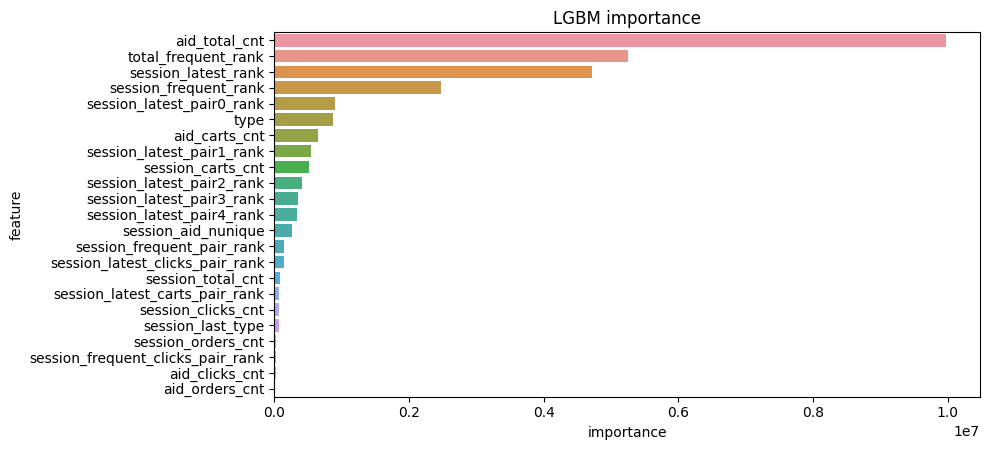

In [19]:
try:
    main()
except Exception as e:
    logger.error(traceback.format_exc())
    line_notify.send(f"{cfg.exp_name} | ERROR!!\n{traceback.format_exc()}")